<a href="https://colab.research.google.com/github/scaomath/wustl-math450/blob/main/Lectures/Math_450_Notebook_6_(GD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!wget https://sites.wustl.edu/scao/files/2021/03/MNIST.tar_.gz
!mv MNIST.tar_.gz MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-11 15:14:20--  https://sites.wustl.edu/scao/files/2021/03/MNIST.tar_.gz
Resolving sites.wustl.edu (sites.wustl.edu)... 34.216.237.15, 34.215.37.29
Connecting to sites.wustl.edu (sites.wustl.edu)|34.216.237.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cpb-us-w2.wpmucdn.com/sites.wustl.edu/dist/1/2774/files/2021/03/MNIST.tar_.gz [following]
--2021-03-11 15:14:24--  https://cpb-us-w2.wpmucdn.com/sites.wustl.edu/dist/1/2774/files/2021/03/MNIST.tar_.gz
Resolving cpb-us-w2.wpmucdn.com (cpb-us-w2.wpmucdn.com)... 151.139.244.23
Connecting to cpb-us-w2.wpmucdn.com (cpb-us-w2.wpmucdn.com)|151.139.244.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23197619 (22M) [application/gzip]
Saving to: ‘MNIST.tar_.gz’

MNIST.tar_.gz       100%[===================>]  22.12M  --.-KB/s    in 0.1s    

2021-03-11 15:14:24 (172 MB/s) - ‘MNIST.tar_.gz’ saved [23197619/23197619]

./MNIST/
./MNIST/processed/
./MNIST/raw/
./MNIST/ra

# Coding lecture 6 of Math 450

## Last two weeks

- Explore MNIST dataset.
- Generator, iterator, `iter()`, `next()`, `enumerate()`, `try: except:` flow control.
- Matrix-vector multiplications and "broadcastability".
- `loss.backward()` vs hand computation.

## Today
- Why `with torch.no_grad():` is necessary.
- Build simple neural network using `torch.nn.Sequential()`
- Gradient descent for a binary classification problem.
- (if time allows) Class and object-oriented programming primer. `constructor`, inheritance, `super`.

In [33]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

import torch
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [34]:
np.newaxis

# MNIST
- Load the data. Both train and validation (test) data.
- Extract only 0, 1 labeled data.
- Write a loss function compute the cross entropy.
- Apply the gradient descent.

In [38]:
# load the mnist data
train = datasets.MNIST(root='./', 
                       train=True, 
                       download=True, 
                       transform = transforms.ToTensor())
valid = datasets.MNIST(root='./', 
                       train=False, 
                       download=True, 
                       transform = transforms.ToTensor())

In [ ]:
print(len(train), len(valid))

60000 10000


In [ ]:
arr1 = train.targets[:30].clone()
print(arr1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7])


In [ ]:
arr1 == 0 # boolean mask

tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False])

In [ ]:
arr1[arr1 == 0]

tensor([0, 0])

In [ ]:
(arr1 == 1) | (arr1 == 0)  
# | is vectorized OR operation (order of operation highest)
# & is vectorized AND

tensor([False,  True, False,  True, False, False,  True, False,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True, False,  True,  True, False, False, False, False, False])

In [ ]:
idx_tr = (train.targets == 0) | (train.targets == 1) 
# getting 0 and 1 labeled data
target_tr = train.targets[idx_tr]
train_new = train.train_data[idx_tr].clone()/255.0

In [ ]:
idx_valid = (valid.targets == 0) | (valid.targets == 1) # getting 0 and 1 labeled data
target_val = valid.targets[idx_valid]
valid_new = valid.test_data[idx_valid].clone()/255.0

In [ ]:
print(len(train_new), len(valid_new))

12665 2115


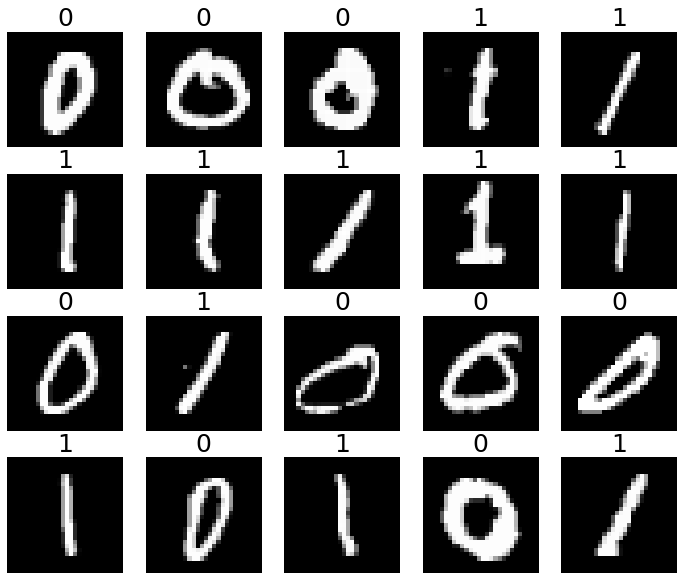

In [ ]:
fig, axes = plt.subplots(4,5, figsize=(12,10))
axes = axes.flatten()
indices = np.random.randint(0,len(train_new),size=20)
# randomly choose 20 of them
for i, idx in enumerate(indices):
    X = train_new[idx].clone().detach()/255
    y = target_tr[idx]
    axes[i].imshow(X, cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y)), color= 'black', fontsize=25)
plt.show()

In [ ]:
# cross-entropy loss

def cross_entropy_loss(yhat, y):
    '''
    Compute the cross entropy of yhat against y
      - yhat: the sigmoid of the output of an NN (output of the model)
      - y: 0 or 1, true target
    '''
    assert y.size() == yhat.size()
    loss = - y * torch.log(yhat) - (1-y) * torch.log(1-yhat)
    return loss.mean()

def sigmoid(yhat):
    return 1/(1 + torch.exp(-yhat))

These functions are implemented in Functional module in `torch`.

In [ ]:
# explain why the implementation above is naturally vectorized
# randomly generate yhat

# the dimension has to be consistent for yhat and y

yhat = torch.randn((10,))
yhat = sigmoid(yhat)  
# sigmoid makes a random variable between (0, 1)
y = target_tr[:10]

In [ ]:
target_tr[:20]

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1])

In [ ]:
print(y.size(), yhat.size())

torch.Size([10]) torch.Size([10])


In [ ]:
- y * torch.log(yhat) - (1-y) * torch.log(1-yhat) 
# 10 samples, a cross-entropy loss for each sample

tensor([1.6609, 1.7825, 0.2455, 0.4183, 2.3724, 0.4298, 0.9289, 0.8847, 2.2815,
        1.4735])

In [ ]:
(- y * torch.log(yhat) - (1-y) * torch.log(1-yhat) ).mean()
# mean = 1/N*sum_N (blahblahblah)

tensor(1.2478)

In [ ]:
(y.size() == yhat.size())

True

In [ ]:
## this would yield bad results
yhat = torch.randn((5,1))
yhat = sigmoid(yhat)
y = target_tr[:5]

In [ ]:
yhat

tensor([[0.4158],
        [0.3148],
        [0.5614],
        [0.8313],
        [0.4611]])

In [ ]:
y

tensor([0, 1, 1, 1, 1])

In [ ]:
(y.size() == yhat.size())

False

In [ ]:
- y * torch.log(yhat) - (1-y) * torch.log(1-yhat)

tensor([[0.5375, 0.8776, 0.8776, 0.8776, 0.8776],
        [0.3781, 1.1557, 1.1557, 1.1557, 1.1557],
        [0.8242, 0.5773, 0.5773, 0.5773, 0.5773],
        [1.7796, 0.1848, 0.1848, 0.1848, 0.1848],
        [0.6182, 0.7742, 0.7742, 0.7742, 0.7742]])

In [ ]:
y * torch.log(yhat) # avoid doing this

tensor([[-0.0000, -0.8776, -0.8776, -0.8776, -0.8776],
        [-0.0000, -1.1557, -1.1557, -1.1557, -1.1557],
        [-0.0000, -0.5773, -0.5773, -0.5773, -0.5773],
        [-0.0000, -0.1848, -0.1848, -0.1848, -0.1848],
        [-0.0000, -0.7742, -0.7742, -0.7742, -0.7742]])

# `nn.Sequential()`

- An NN container for LEGO'ing layers.
- Good for beginners like us.

In [ ]:
import torch.nn as nn
from torchsummary import summary

In [ ]:
model = nn.Sequential(
            nn.Linear(784, 128), # 784 = 28*28
            nn.ReLU(), # activation
            nn.Linear(128, 32), # 2nd hidden layer
            nn.ReLU(),
            nn.Linear(32, 1) # output layer
        )

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
num_params = 0
for param in model.parameters():
    print(param.size())
    # numel function counts the number of entries
    num_params += torch.numel(param) 
# total number of parameters
print(num_params)

torch.Size([128, 784])
torch.Size([128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
104641


In [ ]:
# demonstrate summary
summary(model, input_size=(784, ), device='cpu') 
# -1 means batch_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 32]           4,128
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 104,641
Trainable params: 104,641
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.40
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [ ]:
# class implementation which we will cover in next class
class MLP(nn.Module):
    def __init__(self):
        # super is a keyword for 
        # constructor inheritance
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        # train data (-1, 28, 28) --> (-1, 28*28)
        # in the implementation above
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

# Gradient descent
For $k=0,1,\dots$, update $W_{k+1} = W_k - \alpha \nabla_W L|_{W=W_k}$, where $W$ stands for the parameters of the NN.

In [ ]:
# hyper-parameters, data preparation,  initialize the model

numEpochs = 20 
# number of epochs, 1 epoch means the model sweeps train data set once
learning_rate = 1e-2 # alpha 

model = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

X = train_new.view(train_new.size(0), -1) # automatic flatten the data
# X needs to have size (-1, 784), -1 means data size
y = target_tr.view(-1,1)
print(X.size(), y.size())

In [ ]:
train_new.size()

torch.Size([12665, 28, 28])

In [ ]:
arr = sigmoid(torch.randn(10, ))

In [ ]:
arr

tensor([0.5162, 0.5881, 0.4051, 0.6097, 0.1037, 0.5539, 0.4383, 0.5526, 0.7177,
        0.4607])

In [ ]:
(arr > 0.5).float()

tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 0.])

In [ ]:
y_hat.size()

torch.Size([12665, 1])

In [ ]:
### cpu code

for i, epoch in enumerate(range(numEpochs)):

    y_hat = model(X) # yhat is real number
    y_hat = sigmoid(y_hat) # yhat becomes a proba

    loss = cross_entropy_loss(y_hat, y)
    
    print(f"cross entropy loss after {i}", 
          f"iterations is {loss.item()}",)
    
    # accuracy
    preds = (y_hat > 0.5).detach().float()
    acc = (preds == y).float().mean()
    print(f"accuracy: {100*acc:.2f} \n")

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # autograd to do backprop
    loss.backward()

    # GD
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
            # after .backward()
            # param.grad returns the gradient of each param

cross entropy loss after 0 iterations is 0.687397837638855
accuracy: 56.15 

cross entropy loss after 1 iterations is 0.6820796132087708
accuracy: 58.59 

cross entropy loss after 2 iterations is 0.6768348217010498
accuracy: 62.04 

cross entropy loss after 3 iterations is 0.6716567873954773
accuracy: 66.97 

cross entropy loss after 4 iterations is 0.6665410399436951
accuracy: 71.69 

cross entropy loss after 5 iterations is 0.6614825129508972
accuracy: 76.58 

cross entropy loss after 6 iterations is 0.6564759016036987
accuracy: 81.15 

cross entropy loss after 7 iterations is 0.6515145897865295
accuracy: 84.97 

cross entropy loss after 8 iterations is 0.6465967297554016
accuracy: 88.17 

cross entropy loss after 9 iterations is 0.6417169570922852
accuracy: 90.80 

cross entropy loss after 10 iterations is 0.6368739604949951
accuracy: 92.89 

cross entropy loss after 11 iterations is 0.6320624947547913
accuracy: 94.20 

cross entropy loss after 12 iterations is 0.6272779107093811
ac

In [ ]:
# preparation for GPU code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
)

## GPU training: 

- faster but less accurate (fp32 vs fp64 on CPU)


In [ ]:
X = train_new.view(train_new.size(0), -1).float().to(device)
y = target_tr.view(-1,1).float().to(device)
learning_rate = 1e-2
numEpochs = 20

In [ ]:
for i, epoch in enumerate(range(numEpochs)):
    

    y_hat = model(X) # yhat is real number
    y_hat = sigmoid(y_hat) # yhat becomes a proba

    loss = cross_entropy_loss(y_hat, y)
    
    print(f"cross entropy loss after {i}", 
          f"iterations is {loss.item()}",)
    
    # accuracy
    preds = (y_hat > 0.5).detach().cpu().float()
    _y = y.cpu()
    acc = (preds == _y).float().cpu().mean()
    print(f"accuracy: {100*acc:.2f} \n")

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # autograd to do backprop
    loss.backward()

    # GD
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
            # after .backward()
            # param.grad returns the gradient of each param

cross entropy loss after 0 iterations is 0.6959707140922546
accuracy: 40.38 

cross entropy loss after 1 iterations is 0.6914499402046204
accuracy: 42.81 

cross entropy loss after 2 iterations is 0.6869994401931763
accuracy: 44.58 

cross entropy loss after 3 iterations is 0.6826134324073792
accuracy: 45.80 

cross entropy loss after 4 iterations is 0.6782851219177246
accuracy: 47.10 

cross entropy loss after 5 iterations is 0.6740078330039978
accuracy: 48.50 

cross entropy loss after 6 iterations is 0.6697750687599182
accuracy: 50.19 

cross entropy loss after 7 iterations is 0.6655825972557068
accuracy: 53.05 

cross entropy loss after 8 iterations is 0.6614255905151367
accuracy: 56.77 

cross entropy loss after 9 iterations is 0.6572970151901245
accuracy: 60.88 

cross entropy loss after 10 iterations is 0.653195321559906
accuracy: 65.50 

cross entropy loss after 11 iterations is 0.6491172909736633
accuracy: 70.39 

cross entropy loss after 12 iterations is 0.6450575590133667
ac